In [28]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit


from scipy import stats
from sklearn import metrics
import folium

import math

from descartes import PolygonPatch

In [2]:
### Consts
datapath = '../rawdata/sensors/'
filename = datapath + 'nodes.txt'

### Loading external datasets

In [3]:
## loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')

## loading taxi
taxi = pd.read_pickle('../data/taxi/taxi.pkl')

## loading wind speed
windSpeed = pd.read_pickle('../data/weather/weather.pkl')
windSpeed = windSpeed.resample('H').agg({'Spd[Wind]': 'mean'})

### Calculating the largest intersection across datasets

In [4]:
noiseComplaints_start, noiseComplaints_end = noiseComplaints.index[0], noiseComplaints.index[-1]
taxi_start, taxi_end = taxi.index[0], taxi.index[-1]
windSpeed_start, windSpeed_end = windSpeed.index[0], windSpeed.index[-1]

## Calculating the largest intersection
intersection_start = max(noiseComplaints_start, taxi_start, windSpeed_start)
intersection_end = min(noiseComplaints_end, taxi_end, windSpeed_end)

print('311 Range: ', noiseComplaints_start, '----', noiseComplaints_end)
print('Taxi Range: ', taxi_start, '----', taxi_end)
print('Wind Speed Range: ', windSpeed_start,'----', windSpeed_end)
print('Largest Intersection: ', intersection_start,'----', intersection_end)

311 Range:  2010-01-01 00:03:46 ---- 2019-01-28 02:11:59
Taxi Range:  2017-01-01 00:00:00 ---- 2018-07-01 23:46:41
Wind Speed Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Largest Intersection:  2017-01-01 00:00:00 ---- 2018-04-02 00:00:00


### Loading Time Series

In [7]:
# Load sensors
selectedsensors = [ "sonycnode-b827eb0fedda.sonyc",
                    "sonycnode-b827eb42bd4a.sonyc",
                    "sonycnode-b827eb44506f.sonyc",
                    "sonycnode-b827eb73e772.sonyc",
#                     "sonycnode-b827eb74a519.sonyc",
                    "sonycnode-b827eb84deb5.sonyc",
                    "sonycnode-b827ebb40450.sonyc"]



f = open(filename)
sensors = {}

for line in f:
    s, lat, lon = line.split(' ')
    if s in selectedsensors:
        
        print('Collecting for sensor ', s)
        
        # collection sensor metadata
        sensors[s] = {}
        sensors[s]['lat'] = float(lat)
        sensors[s]['lon'] = float(lon)
        
        # calculating the taxi region to which the sensor belongs
        sensors[s]['taxi_region'] = getSensorLocation(sensors[s]['lat'], sensors[s]['lon'])
        
        # loading sensor data
        sensorData = pd.read_pickle(datapath +s+ '.pkl')
        
        # calculating the intersection with the external datasets
        sensorData_start, sensorData_end = sensorData.index[0], sensorData.index[-1]
        dataframe_start, dataframe_end = max(sensorData_start, intersection_start), min(sensorData_end, intersection_end)
        
        # creating empty timeseries
        df_timeseries = pd.DataFrame()
        df_timeseries['datetime'] = pd.date_range(dataframe_start, dataframe_end, freq="1h")
        df_timeseries.set_index(['datetime'], inplace = True)
        
        # calculating the average over one hour of SPL
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        
        # adding sensor data to the empty dataframe
        df_timeseries['dbas'] = sensorData['dbas'][dataframe_start:dataframe_end]
        
        # adding wind speed to the dataframe
        df_timeseries['wind'] = windSpeed[dataframe_start:dataframe_end]
        
        # adding 311 data to the empty dataframe
        ############################
        #SPEEDING UP FOR THIS CASE#
        ###########################
        #################################################################
        noiseComplaints_temp = noiseComplaints['2017-12-31':'2018-12-31']
        #################################################################
        noiseComplaints_temp = noiseComplaints[noiseComplaints.apply(lambda row: pointWithinCircle([row['Latitude'], row['Longitude']], [lat, lon, 200]), axis=1)]
        noiseComplaints_temp = noiseComplaints_temp.resample('H').agg({'Descriptor': 'count'})
        noiseComplaints_temp.rename({'Descriptor':'noise'}, inplace=True)
        df_timeseries['noise'] = noiseComplaints_temp[dataframe_start:dataframe_end]
        
        # adding taxi data to the empty dataframe
        taxi_temp = taxi[taxi['location'] == sensors[s]['taxi_region']]
        taxi_temp = taxi_temp.resample('H').agg({'location': 'count'})
        taxi_temp.rename({'location':'trips'}, inplace=True)
        df_timeseries['taxi'] = taxi_temp[dataframe_start:dataframe_end]
                
        # filling the missing entries with 0
        df_timeseries.fillna(df_timeseries.mean(), inplace=True)
        df_timeseries['dbas'] = df_timeseries['dbas'].astype(int)
        
        # adding cos and sin to the dataframe
        df_timeseries['hour'] = df_timeseries.index.hour
        df_timeseries['hour_sin'] = np.sin(df_timeseries['hour'])
        df_timeseries['hour_cos'] = np.cos(df_timeseries['hour'])
        
        # attach the complete dataframe to a given sensor
        sensors[s]['dataframe'] = df_timeseries 

### Creating error matrix

In [8]:
# error matrix for bin distance
errorMatrix_binDistance = pd.DataFrame(0.0, index=np.arange(len(selectedsensors)), columns=selectedsensors)
errorMatrix_binDistance['index'] = selectedsensors
errorMatrix_binDistance.set_index(errorMatrix_binDistance['index'], inplace=True)
errorMatrix_binDistance.drop(columns=['index'], inplace=True)

# error matrix for accuracy
errorMatrix_accuracy = pd.DataFrame(0.0, index=np.arange(len(selectedsensors)), columns=selectedsensors)
errorMatrix_accuracy['index'] = selectedsensors
errorMatrix_accuracy.set_index(errorMatrix_accuracy['index'], inplace=True)
errorMatrix_accuracy.drop(columns=['index'], inplace=True)

### Building the model

In [9]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

Training sensor  sonycnode-b827eb0fedda.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827eb0fedda.sonyc  with  sonycnode-b827eb42bd4a.sonyc


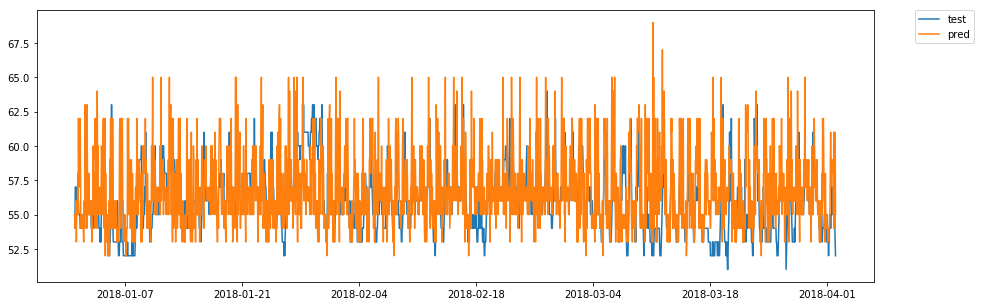

Accuracy:  0.15835240274599544
Bin Distance:  2.3354691075514875
113    0.000047
Name: Shape_Area, dtype: float64
64    0.000082
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb0fedda.sonyc  with  sonycnode-b827eb44506f.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


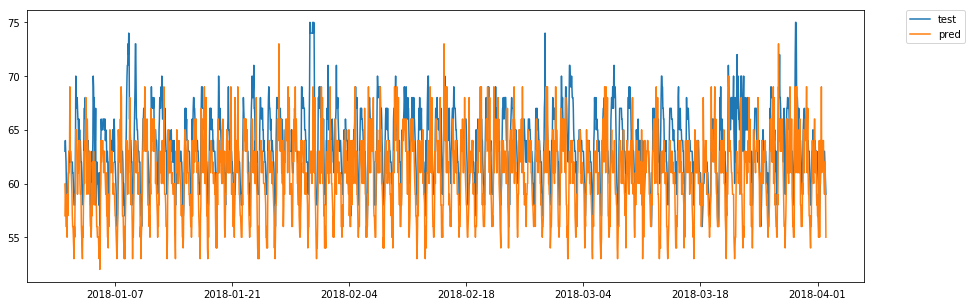

Accuracy:  0.06681922196796339
Bin Distance:  3.4407322654462242
113    0.000047
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb0fedda.sonyc  with  sonycnode-b827eb73e772.sonyc


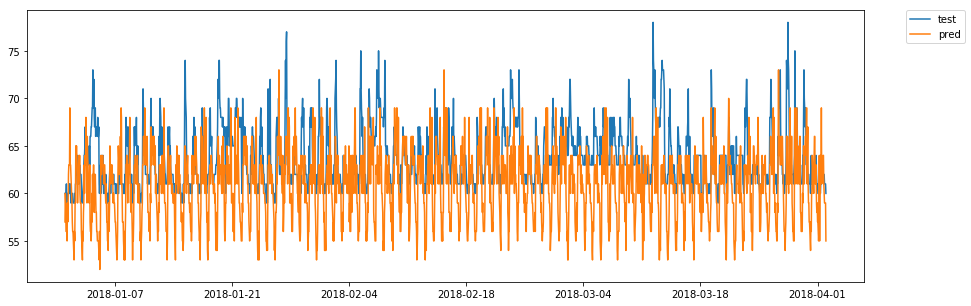

Accuracy:  0.07780320366132723
Bin Distance:  3.7903890160183065
113    0.000047
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb0fedda.sonyc  with  sonycnode-b827eb84deb5.sonyc


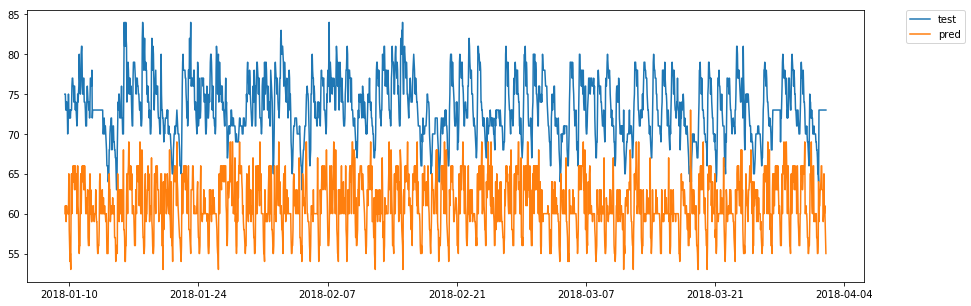

Accuracy:  0.00101010101010101
Bin Distance:  12.284343434343434
113    0.000047
Name: Shape_Area, dtype: float64
160    0.000072
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb0fedda.sonyc  with  sonycnode-b827ebb40450.sonyc


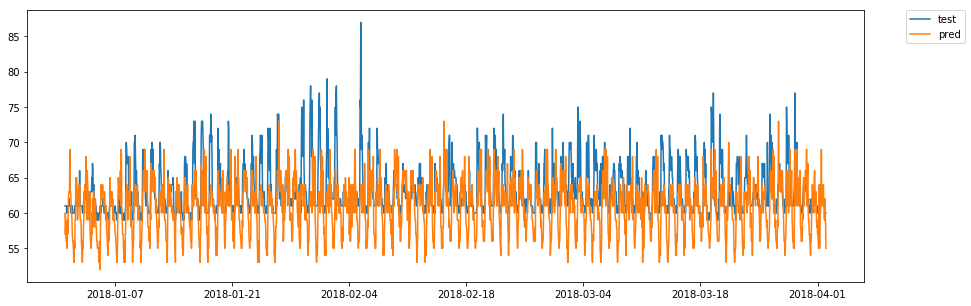

Accuracy:  0.07643020594965676
Bin Distance:  3.460411899313501
113    0.000047
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Training sensor  sonycnode-b827eb42bd4a.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827eb42bd4a.sonyc  with  sonycnode-b827eb0fedda.sonyc


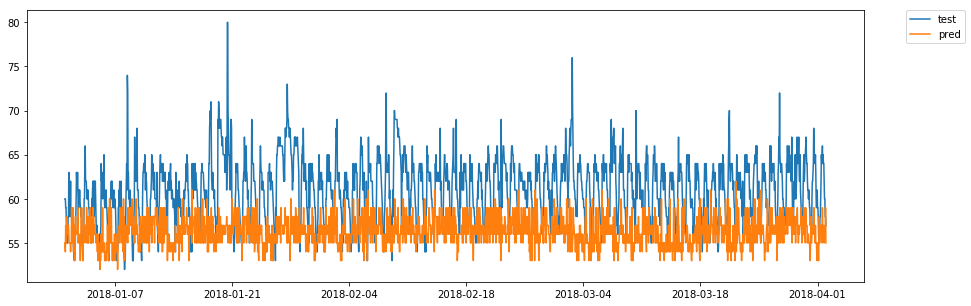

Accuracy:  0.04576659038901602
Bin Distance:  5.092906178489702
64    0.000082
Name: Shape_Area, dtype: float64
113    0.000047
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb42bd4a.sonyc  with  sonycnode-b827eb44506f.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


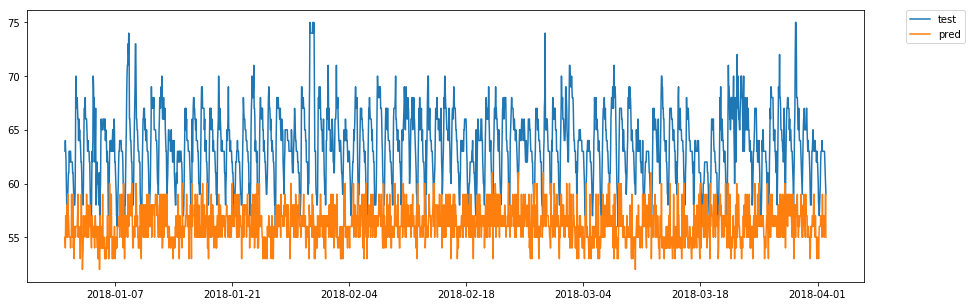

Accuracy:  0.013272311212814645
Bin Distance:  7.388100686498856
64    0.000082
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb42bd4a.sonyc  with  sonycnode-b827eb73e772.sonyc


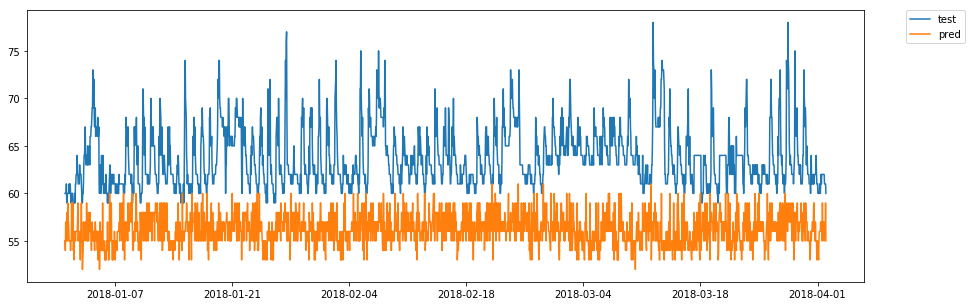

Accuracy:  0.004576659038901602
Bin Distance:  7.478260869565218
64    0.000082
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb42bd4a.sonyc  with  sonycnode-b827eb84deb5.sonyc


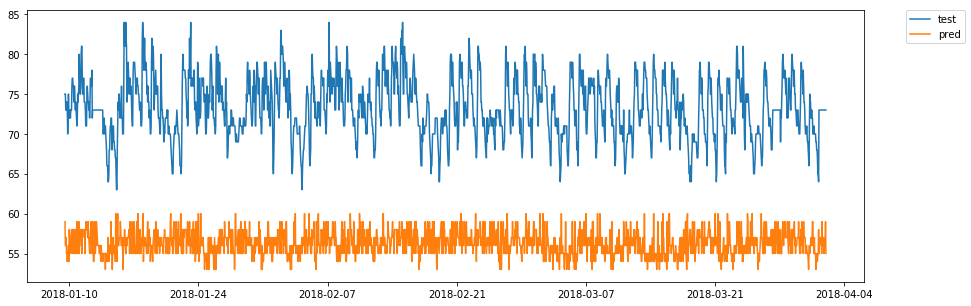

Accuracy:  0.0
Bin Distance:  17.013131313131314
64    0.000082
Name: Shape_Area, dtype: float64
160    0.000072
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb42bd4a.sonyc  with  sonycnode-b827ebb40450.sonyc


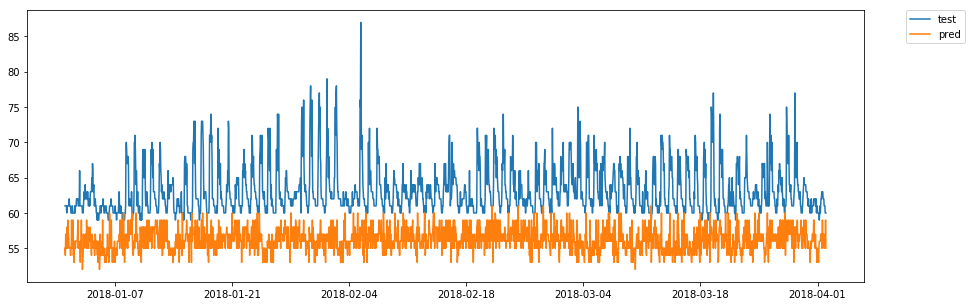

Accuracy:  0.006864988558352402
Bin Distance:  6.94324942791762
64    0.000082
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Training sensor  sonycnode-b827eb44506f.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827eb44506f.sonyc  with  sonycnode-b827eb0fedda.sonyc


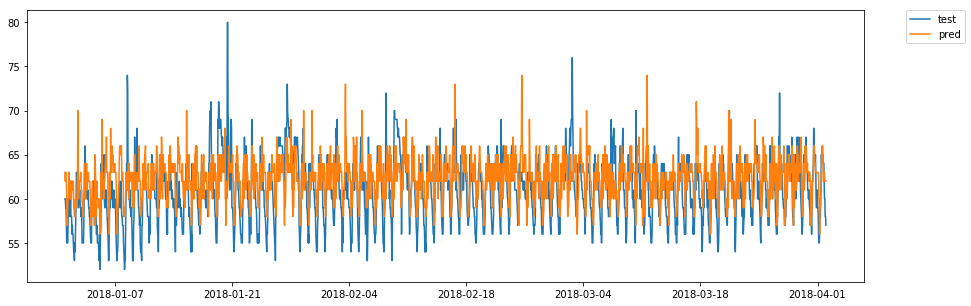

Accuracy:  0.09931350114416476
Bin Distance:  2.802745995423341
112    0.000058
Name: Shape_Area, dtype: float64
113    0.000047
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb44506f.sonyc  with  sonycnode-b827eb42bd4a.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


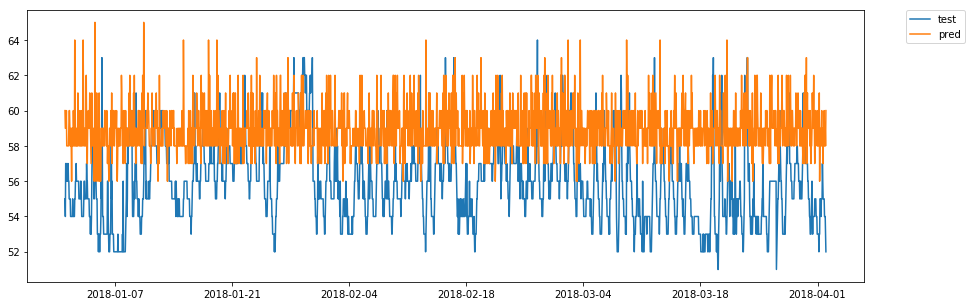

Accuracy:  0.06727688787185354
Bin Distance:  3.368878718535469
112    0.000058
Name: Shape_Area, dtype: float64
64    0.000082
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb44506f.sonyc  with  sonycnode-b827eb73e772.sonyc


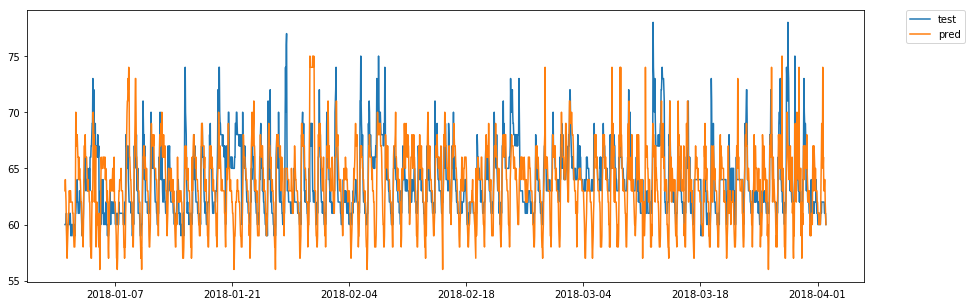

Accuracy:  0.128604118993135
Bin Distance:  2.376201372997712
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb44506f.sonyc  with  sonycnode-b827eb84deb5.sonyc


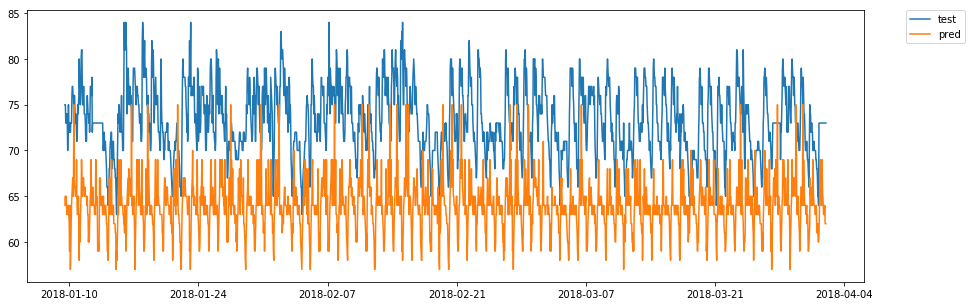

Accuracy:  0.0030303030303030303
Bin Distance:  9.465151515151515
112    0.000058
Name: Shape_Area, dtype: float64
160    0.000072
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb44506f.sonyc  with  sonycnode-b827ebb40450.sonyc


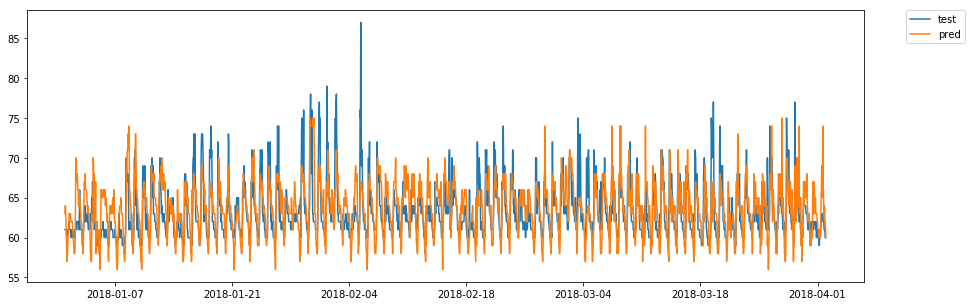

Accuracy:  0.12677345537757437
Bin Distance:  2.217391304347826
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Training sensor  sonycnode-b827eb73e772.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827eb73e772.sonyc  with  sonycnode-b827eb0fedda.sonyc


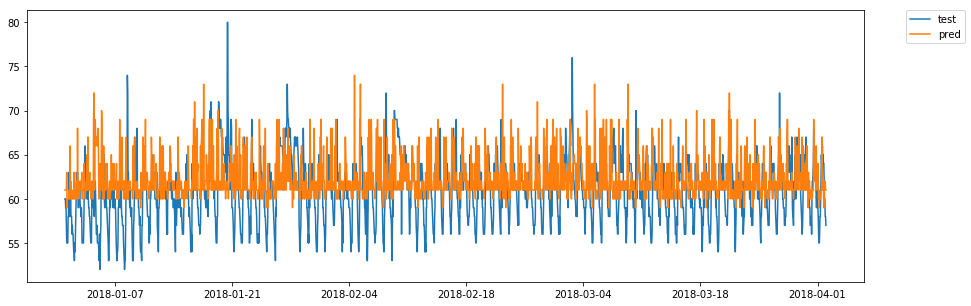

Accuracy:  0.07505720823798627
Bin Distance:  3.2068649885583524
112    0.000058
Name: Shape_Area, dtype: float64
113    0.000047
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb73e772.sonyc  with  sonycnode-b827eb42bd4a.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


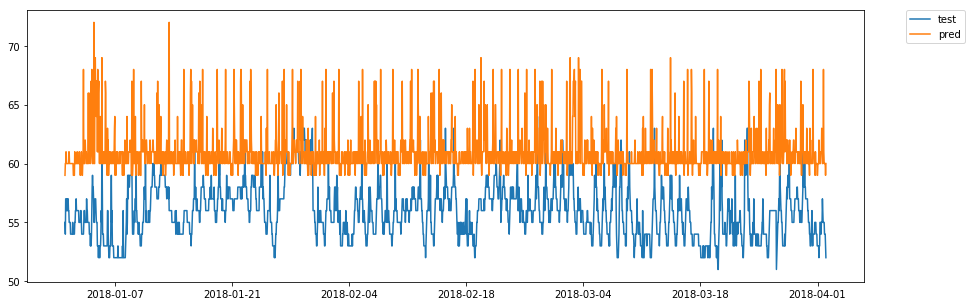

Accuracy:  0.02517162471395881
Bin Distance:  5.117620137299771
112    0.000058
Name: Shape_Area, dtype: float64
64    0.000082
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb73e772.sonyc  with  sonycnode-b827eb44506f.sonyc


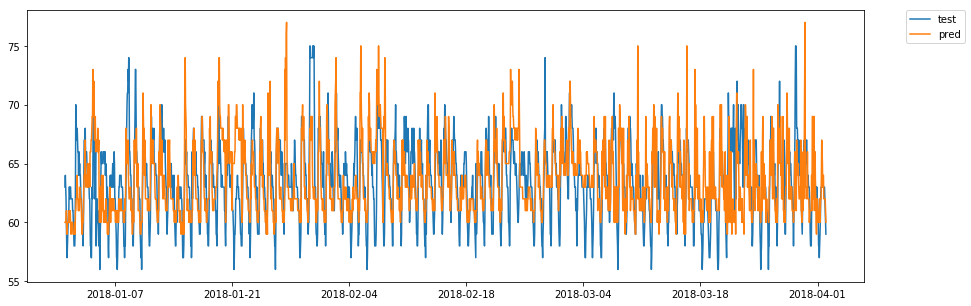

Accuracy:  0.13501144164759726
Bin Distance:  2.3789473684210525
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb73e772.sonyc  with  sonycnode-b827eb84deb5.sonyc


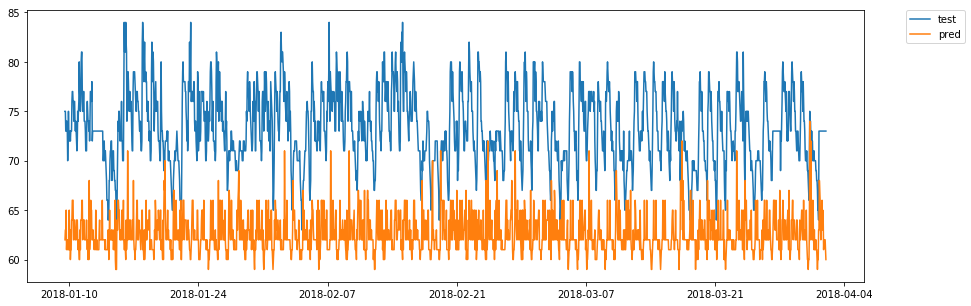

Accuracy:  0.0035353535353535356
Bin Distance:  10.732323232323232
112    0.000058
Name: Shape_Area, dtype: float64
160    0.000072
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb73e772.sonyc  with  sonycnode-b827ebb40450.sonyc


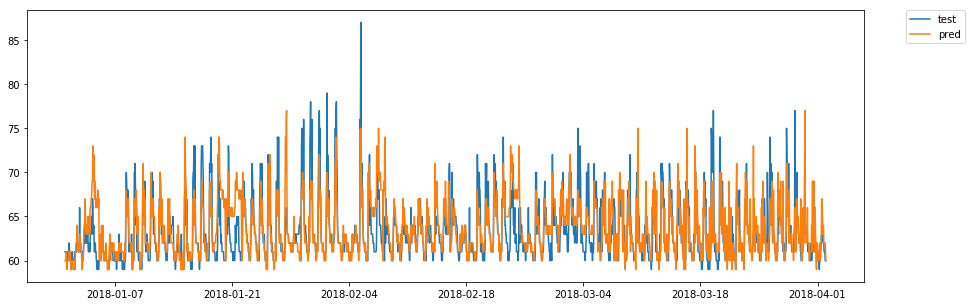

Accuracy:  0.28787185354691075
Bin Distance:  1.7441647597254004
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Training sensor  sonycnode-b827eb84deb5.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827eb84deb5.sonyc  with  sonycnode-b827eb0fedda.sonyc


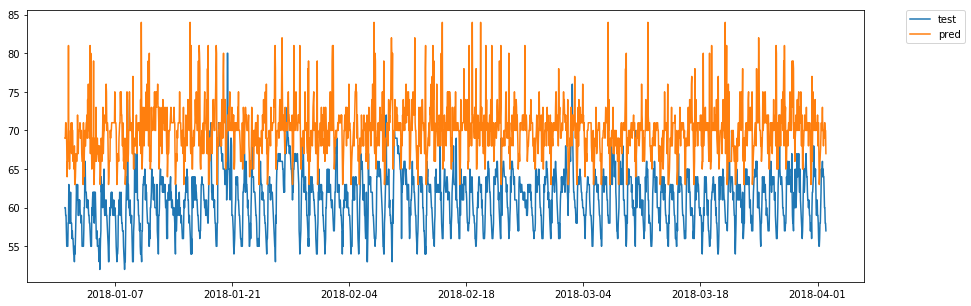

Accuracy:  0.006407322654462242
Bin Distance:  9.05812356979405
160    0.000072
Name: Shape_Area, dtype: float64
113    0.000047
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb84deb5.sonyc  with  sonycnode-b827eb42bd4a.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


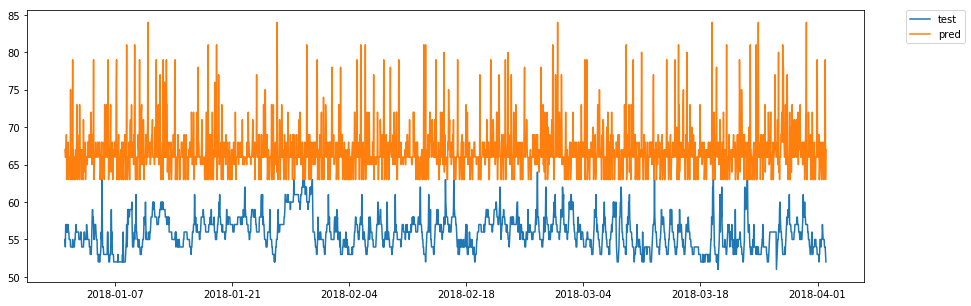

Accuracy:  0.0013729977116704805
Bin Distance:  10.94050343249428
160    0.000072
Name: Shape_Area, dtype: float64
64    0.000082
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb84deb5.sonyc  with  sonycnode-b827eb44506f.sonyc


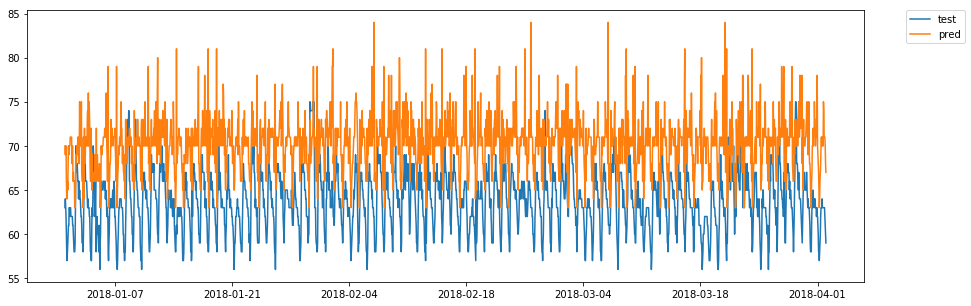

Accuracy:  0.013272311212814645
Bin Distance:  6.728146453089245
160    0.000072
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb84deb5.sonyc  with  sonycnode-b827eb73e772.sonyc


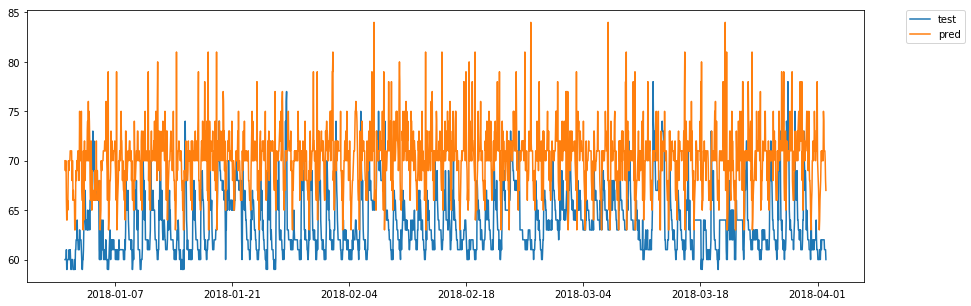

Accuracy:  0.02379862700228833
Bin Distance:  6.750114416475973
160    0.000072
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827eb84deb5.sonyc  with  sonycnode-b827ebb40450.sonyc


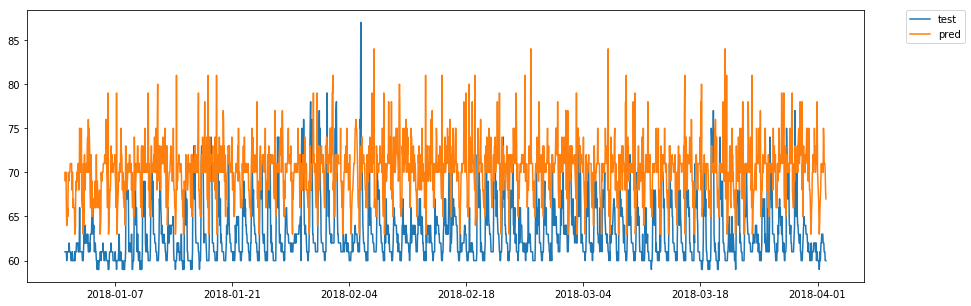

Accuracy:  0.019221967963386728
Bin Distance:  7.279633867276888
160    0.000072
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Training sensor  sonycnode-b827ebb40450.sonyc :


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Comparing sensor  sonycnode-b827ebb40450.sonyc  with  sonycnode-b827eb0fedda.sonyc


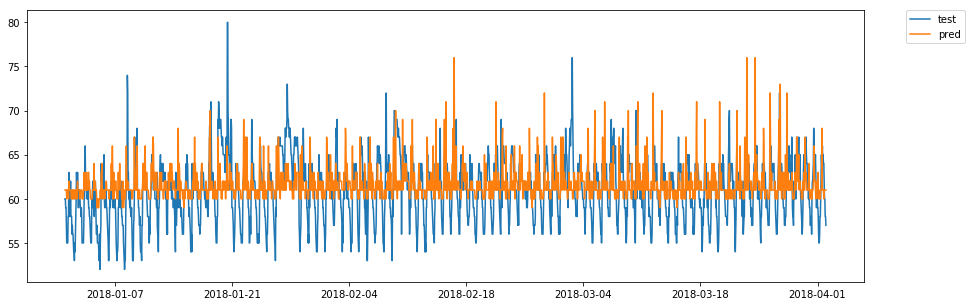

Accuracy:  0.09565217391304348
Bin Distance:  2.7784897025171627
112    0.000058
Name: Shape_Area, dtype: float64
113    0.000047
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827ebb40450.sonyc  with  sonycnode-b827eb42bd4a.sonyc


/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


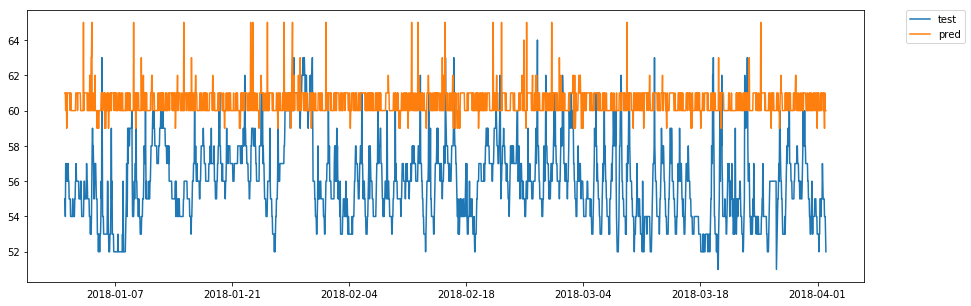

Accuracy:  0.032036613272311214
Bin Distance:  4.644393592677345
112    0.000058
Name: Shape_Area, dtype: float64
64    0.000082
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827ebb40450.sonyc  with  sonycnode-b827eb44506f.sonyc


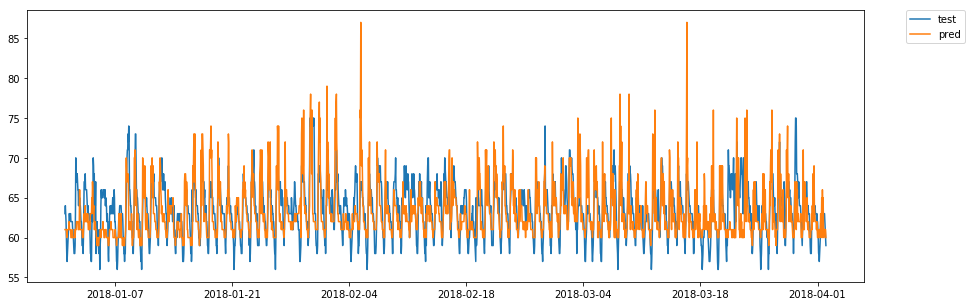

Accuracy:  0.12173913043478261
Bin Distance:  2.3244851258581236
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827ebb40450.sonyc  with  sonycnode-b827eb73e772.sonyc


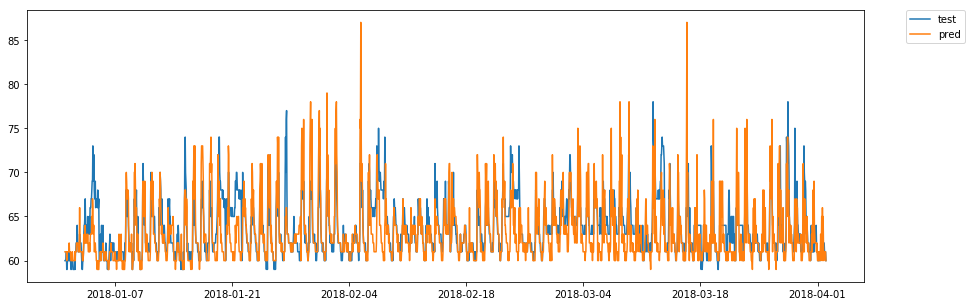

Accuracy:  0.2773455377574371
Bin Distance:  1.8521739130434782
112    0.000058
Name: Shape_Area, dtype: float64
112    0.000058
Name: Shape_Area, dtype: float64
Comparing sensor  sonycnode-b827ebb40450.sonyc  with  sonycnode-b827eb84deb5.sonyc


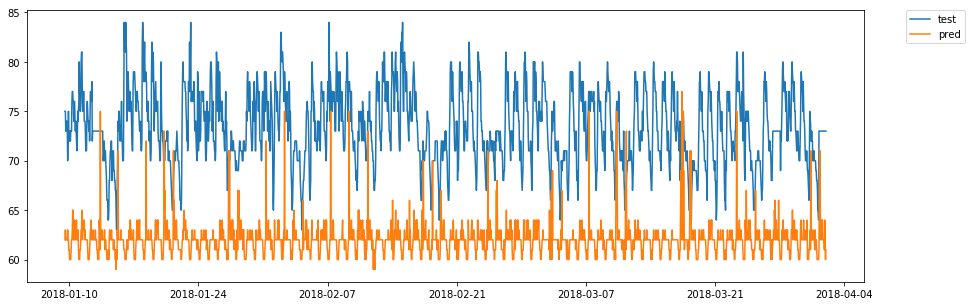

Accuracy:  0.0025252525252525255
Bin Distance:  11.336868686868687
112    0.000058
Name: Shape_Area, dtype: float64
160    0.000072
Name: Shape_Area, dtype: float64


In [63]:
# TODO: Remove sensor sonycnode-b827eb74a519.sonyc from the model

for sensor in sensors:
    
#     if(sensor != 'sonycnode-b827eb74a519.sonyc'):
        
    print('Training sensor ', sensor, ':')

    X = sensors[sensor]['dataframe'][['noise','taxi', 'wind', 'hour_sin', 'hour_cos']]
    y = sensors[sensor]['dataframe'][['dbas']]

    estimator, y_test, y_pred = runEstimator(X, y, classifier, 'continuous')

    ## Comparing the trained model with other models
    for comparingSensor in sensors:
        if(comparingSensor != sensor):
            print('Comparing sensor ', sensor, ' with ', comparingSensor)

            # plotting sensor's position. Red: sensors that generated the model. Blue: input sensor data
            plotSensorPosition(sensors[sensor]['lat'], sensors[sensor]['lon'], sensors[comparingSensor]['lat'], sensors[comparingSensor]['lon'])

            # comparing the model with another sensor's data
            comparingYPred, comparingYTest = compareSensors(estimator, sensors[comparingSensor])

            # plotting both timeseries in a single chart
            plotClassifier(comparingYPred, comparingYTest, sensor)

            # describing error metrics
            accuracy, bin_distance = plotError(comparingYPred, comparingYTest)

            # filling in the error matrix with bin_distance
            errorMatrix_binDistance.loc[sensor][comparingSensor] = float(bin_distance)
            errorMatrix_accuracy.loc[sensor][comparingSensor] = float(accuracy)
        
            # plotting taxi region
            printTaxiRegionSize(sensor, comparingSensor)

In [14]:
## Printing bin distance matrix
errorMatrix_binDistance

,sonycnode-b827eb0fedda.sonyc,sonycnode-b827eb42bd4a.sonyc,sonycnode-b827eb44506f.sonyc,sonycnode-b827eb73e772.sonyc,sonycnode-b827eb84deb5.sonyc,sonycnode-b827ebb40450.sonyc
index,,,,,,
sonycnode-b827eb0fedda.sonyc,0.000000,2.335469,3.440732,3.790389,12.284343,3.460412
sonycnode-b827eb42bd4a.sonyc,5.092906,0.000000,7.388101,7.478261,17.013131,6.943249
sonycnode-b827eb44506f.sonyc,2.802746,3.368879,0.000000,2.376201,9.465152,2.217391
sonycnode-b827eb73e772.sonyc,3.206865,5.117620,2.378947,0.000000,10.732323,1.744165
sonycnode-b827eb84deb5.sonyc,9.058124,10.940503,6.728146,6.750114,0.000000,7.279634
sonycnode-b827ebb40450.sonyc,2.778490,4.644394,2.324485,1.852174,11.336869,0.000000


In [57]:
taxi_regions

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399991...
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,POLYGON ((-74.06367318899999 40.60219816599994...
6,7,0.107417,0.000390,Astoria,7,Queens,POLYGON ((-73.90413637799996 40.76752031699986...
7,8,0.027591,0.000027,Astoria Park,8,Queens,POLYGON ((-73.92334041500001 40.77512891199993...
8,9,0.099784,0.000338,Auburndale,9,Queens,POLYGON ((-73.78502434699996 40.76103651599986...
9,10,0.099839,0.000436,Baisley Park,10,Queens,"POLYGON ((-73.7832662499999 40.68999429299992,..."


In [15]:
## Printing accuracy error matrix
errorMatrix_accuracy

,sonycnode-b827eb0fedda.sonyc,sonycnode-b827eb42bd4a.sonyc,sonycnode-b827eb44506f.sonyc,sonycnode-b827eb73e772.sonyc,sonycnode-b827eb84deb5.sonyc,sonycnode-b827ebb40450.sonyc
index,,,,,,
sonycnode-b827eb0fedda.sonyc,0.000000,0.158352,0.066819,0.077803,0.001010,0.076430
sonycnode-b827eb42bd4a.sonyc,0.045767,0.000000,0.013272,0.004577,0.000000,0.006865
sonycnode-b827eb44506f.sonyc,0.099314,0.067277,0.000000,0.128604,0.003030,0.126773
sonycnode-b827eb73e772.sonyc,0.075057,0.025172,0.135011,0.000000,0.003535,0.287872
sonycnode-b827eb84deb5.sonyc,0.006407,0.001373,0.013272,0.023799,0.000000,0.019222
sonycnode-b827ebb40450.sonyc,0.095652,0.032037,0.121739,0.277346,0.002525,0.000000


### Helper Functions

In [62]:
# loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')

# translating polygon to lat/lng
crs = {'init': 'epsg:4326'}
taxi_regions = taxi_regions.to_crs(crs)


def getSensorLocation(lat, lng):
    ## TODO: Refactor function return
    ## get neighboorhood ID of a coordinate
    point = Point(lng, lat)
    taxi_regions['intersect'] = taxi_regions.apply(lambda row: row['geometry'].intersects(point), axis=1)
    region =  taxi_regions[taxi_regions['intersect'] == True]['LocationID']
    return region.values[0]

## Default radius
radius = 200
def pointWithinCircle(point, circle):
    ## Return if a given point is within a circle
    c = (circle[0], circle[1])
    r = circle[2]
    dist = geopy.distance.distance(c, point).meters
    if dist <= r:
        return True

    return False

def compareSensors(estimator, sensor):
    
    Xlocal = sensor['dataframe'][['noise', 'taxi', 'wind', 'hour_sin', 'hour_cos']]
    ylocal = sensor['dataframe'][['dbas']]
    
    yPredLocal = estimator.predict(Xlocal)
    
    return yPredLocal, ylocal

def runEstimator(X, y, estimator, randomize):

    if(randomize == 'random'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
    elif(randomize == 'continuous'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
    return estimator, y_test, y_pred

def plotClassifier(y_pred, y_test, title):
    
    df_test = pd.DataFrame(y_test)
    df_test['pred'] = y_pred

#     df_test.sort_values(by=['datetime'], inplace=True)
    df_test.sort_index(inplace=True)

    plt.figure(figsize=(15,5))
    plt.plot(df_test['dbas'], label='test')
    plt.plot(df_test['pred'], label='pred')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def plotSensorPosition(rootSensor_lat, rootSensor_lng, comparingSensor_lat, comparingSensor_lng):
    
    map_osm = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
    folium.CircleMarker(location=[rootSensor_lat, rootSensor_lng], radius=5,  fill=True, fill_opacity=0.5, fill_color="red", color="black").add_to(map_osm)
    folium.CircleMarker(location=[comparingSensor_lat, comparingSensor_lng], radius=5,  fill=True, fill_opacity=0.5, fill_color="blue", color="black").add_to(map_osm)                  

    display(map_osm)
    
def plotError(y_pred, y_test):
    
    y_test['pred'] = y_pred
    
    accuracy = metrics.accuracy_score(y_test[['dbas']], y_test[['pred']])
    bin_distance = metrics.mean_absolute_error(y_test[['dbas']],  y_test[['pred']])
    
    print('Accuracy: ', accuracy)
    print('Bin Distance: ', bin_distance)
    
    return accuracy, bin_distance

def printTaxiRegionSize(sensor, comparingSensor):
    print(taxi_regions[taxi_regions['LocationID'] == sensors[sensor]['taxi_region']]['Shape_Area'])
    print(taxi_regions[taxi_regions['LocationID'] == sensors[comparingSensor]['taxi_region']]['Shape_Area'])